# Convergence tests
## Supplemental material for _The  <sup>8</sup>Li<sup>+</sup> site in α-Al<sub>2</sub>O<sub>3</sub>_


W.A. MacFarlane,<sup>1,2,3</sup> J.K. Shenton,<sup>4,*</sup> Z. Salman,<sup>5</sup> A. Chatzichristos,<sup>2,6,7</sup> D.L. Cortie,<sup>8</sup> M. Dehn,<sup>2,6</sup> D. Fujimoto,<sup>2,3,6</sup> V.L. Karner,<sup>1,3,5</sup> R.F. Kiefl,<sup>2,3,6</sup> D. Koumoulis,<sup>9</sup> C.D.P. Levy,<sup>3</sup> R.M.L. McFadden,<sup>1,2,3</sup> I. McKenzie,<sup>3,10,11</sup> G.D. Morris,<sup>3</sup> M.R. Pearson,<sup>3</sup> M. Stachura,<sup>3</sup> J.O. Ticknor<sup>1,2</sup> 

<sup><sub>
<sup>1 </sup>Chemistry Department, University of British Columbia, Vancouver, BC, V6T 1Z1, Canada
<sup>2</sup>Stewart Blusson Quantum Matter Institute, University of British Columbia, Vancouver, BC, V6T 1Z1, Canada
<sup>3</sup><span style="font-variant:small-caps;">Triumf</span>, Vancouver, BC, V6T 2A3 Canada
<sup>4</sup>Scientific Computing Department, Science & Technology Facilities Council, Rutherford Appleton Laboratory, Didcot OX11 0QX, United Kingdom
<sup>5 </sup>Laboratory for Muon Spin Spectroscopy, Paul Scherrer Institute, CH-5232 Villigen PSI, Switzerland
<sup>6</sup>Department of Physics and Astronomy, University of British Columbia, Vancouver, BC, V6T 1Z1, Canada
<sup>7</sup>Physics Department, Khalifa University, United Arab Emirates
<sup>8</sup>Australian Nuclear Science and Technology Organisation, Lucas Heights, New South Wales 2234, Australia
<sup>9</sup>Center for Applied Energy Research, University of Kentucky, Lexington, KY 40511, USA
<sup>10</sup>Department of Chemistry, Simon Fraser University, Burnaby, BC, V5A 1S6, Canada
<sup>11</sup>Department of Physics and Astronomy, University of Waterloo, Waterloo, Ontario, N2L 3G1, Canada
</sup></sub>

<sup>*</sup>For queries about the supplemental material in this repository contact [J. Kane Shenton](mailto:kane.shenton@stfc.ac.uk).


---


### Contents
1. [Summary](#1-summary)
2. [Computational details](#2-computational-details)
3. [Cut-off](#3-plane-wave-cut-off)
   1. [Energy difference](#31-energy-differences)
   2. [Forces](#32-forces)
   3. [Stresses](#33-stresses)
   4. [Structure](#34-final-structure)
4. [_k_-points](#4-k-points)
   1. [Energy difference](#41-energy-differences)
   2. [Forces](#42-forces)
   3. [Stresses](#43-stresses)
   4. [Structure](#44-final-structure)
5. [Supercell size](#5-supercell)
   1. [EFG](#51-efg)
   2. [Structural distortion](#52-structural-distortion)







### 1. Summary


* The plane-wave cut off is well-converged at 900 eV with respect to energy differences, forces, stresses, and final crystal structure. 
* A 6x6x6 k-point mesh is found to be well-converged for a primitive unit cell, and therefore an equivalent k-spacing is used in the reported data.
* The effect of the finite supercell size on predicted EFG tensor of Li in the octahedral interstitial site was found to be negligible going from a 2x2x2 to a 3x3x3 supercell, with only a 0.258% change in the predicted EFG tensor. 





### 2. Computational details

#### Notebook setup

We take our initial structure from the low-temperature (120 K) experimental structure from [Pillet et al.](http://scripts.iucr.org/cgi-bin/paper?S0108767300018626) as obtained from the ICSD, collection code 92631.

This structure has cell parameters:   
a = b = 4.7602(4) Å  
c = 12.993(2) Å  
$\alpha$ = $\beta$ = 90°   
$\gamma$ = 120°   

We include a crystal structure that is based on the experimental structure called: `experimental_structure.cell`. 

In [44]:
# !pip install ase
from ase.io import read
from ase.io.castep import read_castep
from ase import Atoms

# ! pip install spglib
import spglib

# !pip install soprano
# (Useful for NMR processing!)
from soprano.data.nmr import EFG_TO_CHI
from soprano.properties.nmr import EFGVzz


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('./style_figs.mplstyle')
cm = 0.393701 # one cm in inches
# standard figure size 
std_figsize = (8.5*cm, 6*cm)
# user square markers for LDA results and circles for PBEsol results
markers = {'lda':'s', 'pbesol': 'o'}


## optional -- needed if re-running all the calcs. 
# from ase.calculators.castep import Castep 

# Q for 8Li in barn:
Q = 0.0326 # barn


Convert the experimental structure to the rhombohedral cell setting:

In [45]:
atoms_exp_hex = read("experimental_structure.cell")
# swtich to Rhomb. setting for these tests:
cell, scaled_pos, numbers = spglib.find_primitive(atoms_exp_hex)
atoms_exp = Atoms(cell=cell, scaled_positions=scaled_pos, numbers=numbers)
atoms_exp.pbc = True

To run the calculations, we used the atomic simulation environment (ASE). We define a function here to run a CASTEP geometry optimisation for a given structure:

In [46]:
def geom(atoms, cutoff, kpts, xc):
    '''
    Function to set up and run CASTEP geometry optimisation of a given atoms structure, with specified
    plane wave cut off (in eV), k-point mesh and XC functional.
    '''
    label = f"al2o3_xc-{xc.upper()}_c-{cutoff:04d}_k-{kpts[0]}x{kpts[1]}x{kpts[2]}_geom"

    calc = Castep(directory = 'convergence/cutoff_kpts/',
                  label     = label,
                  task      = "GeometryOptimisation")
    calc._set_atoms = True
    calc._rename_existing_dir = False

    # Param settings
    calc.param.xc_functional = xc
    calc.param.cut_off_energy = cutoff
    # Prevent CASTEP from writing *wvfn* files
    calc.param.num_dump_cycles = 0
    calc.param.opt_strategy = 'speed'

    calc.param.write_cell_structure = True
    calc.param.write_cif_structure = True
    calc.param.geom_method = "LBFGS"
    calc.param.geom_force_tol = 0.01 # eV/Å
    calc.param.geom_energy_tol = 1e-5 # eV
    calc.param.geom_stress_tol = 0.1 # GPa
    calc.param.geom_disp_tol = 0.001 # Å
    calc.param.geom_max_iter = 150 # default: 30

    # Cell settings
    calc.cell.kpoint_mp_grid = f'{kpts[0]} {kpts[1]} {kpts[2]}'
    
    atoms.set_calculator(calc)
    E = atoms.get_potential_energy()
    return E

### 3. Plane wave cut off



In [47]:
# We don't need to re-run the calculations as the outputs are provided.
rerun_calcs = False
if rerun_calcs:
    cutoffs = [300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400]
    kpts = [5,5,5]
    for xc in ["lda", "pbesol"]:
        for c in cutoffs:
            atoms = atoms_exp.copy()
            label = f"al2o3_xc-{xc.upper()}_c-{c:04d}_k-{kpts[0]}x{kpts[1]}x{kpts[2]}_geom"
            print(label)
            geom(atoms, c, kpts, xc)

#### Read in the results

Now we extract key information from the results of each geometry optimisation.

In [48]:

cutoffs = [300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400]
kpts = [5,5,5]
encuts_results = {}

for xc in ["lda", "pbesol"]:
    print(f"{xc.upper()}")
    encuts_results[xc] = pd.DataFrame()
    
    energies_i = []
    energies_f = []
    maxforces_i = []
    maxforces_f = []
    maxstresses_i = []
    maxstresses_f = []
    atoms_list = []
    for c in cutoffs:
        # print(f"   Cut off: {c} eV")
        
        label = f"al2o3_xc-{xc.upper()}_c-{c:04d}_k-{kpts[0]}x{kpts[1]}x{kpts[2]}_geom"
        castepfile = f"convergence/cutoff_kpts/{label}.castep"
        # initial energies
        t = !grep "LBFGS: finished iteration     0" $castepfile
        E = float(t[0].split()[-2])
        energies_i.append(E)
        
        # forces:
        t = !grep "|F|max" $castepfile
        maxF_i = float(t[0].split("|")[4])
        maxF_f = float(t[-1].split("|")[4])
        maxforces_i.append(maxF_i)
        maxforces_f.append(maxF_f)
        
        # stresses
        t = !grep "Smax" $castepfile
        maxS_i = float(t[0].split("|")[2])
        maxS_f = float(t[-1].split("|")[2])
        maxstresses_i.append(maxS_i)
        maxstresses_f.append(maxS_f)
        
        # final energies
        atoms = read_castep(castepfile, index=-1)
        energies_f.append(atoms.get_potential_energy())
        atoms_list.append(atoms)
        
    encuts_results[xc]["cutoffs"] = cutoffs
    encuts_results[xc]["energies_i"] = energies_i
    encuts_results[xc]["energies_f"] = energies_f
    encuts_results[xc]["maxforces_i"] = maxforces_i
    encuts_results[xc]["maxforces_f"] = maxforces_f
    encuts_results[xc]["maxstresses_i"] = maxstresses_i
    encuts_results[xc]["maxstresses_f"] = maxstresses_f
    encuts_results[xc]["atoms"] = atoms_list

LDA
PBESOL


#### 3.1 Energy differences

If we plot the difference in total energy between the relaxed and unrelaxed structures with respect to that of the highest cut off energy (1400 eV), we get a sense of how well-converged the energy differences are for a given cut off.

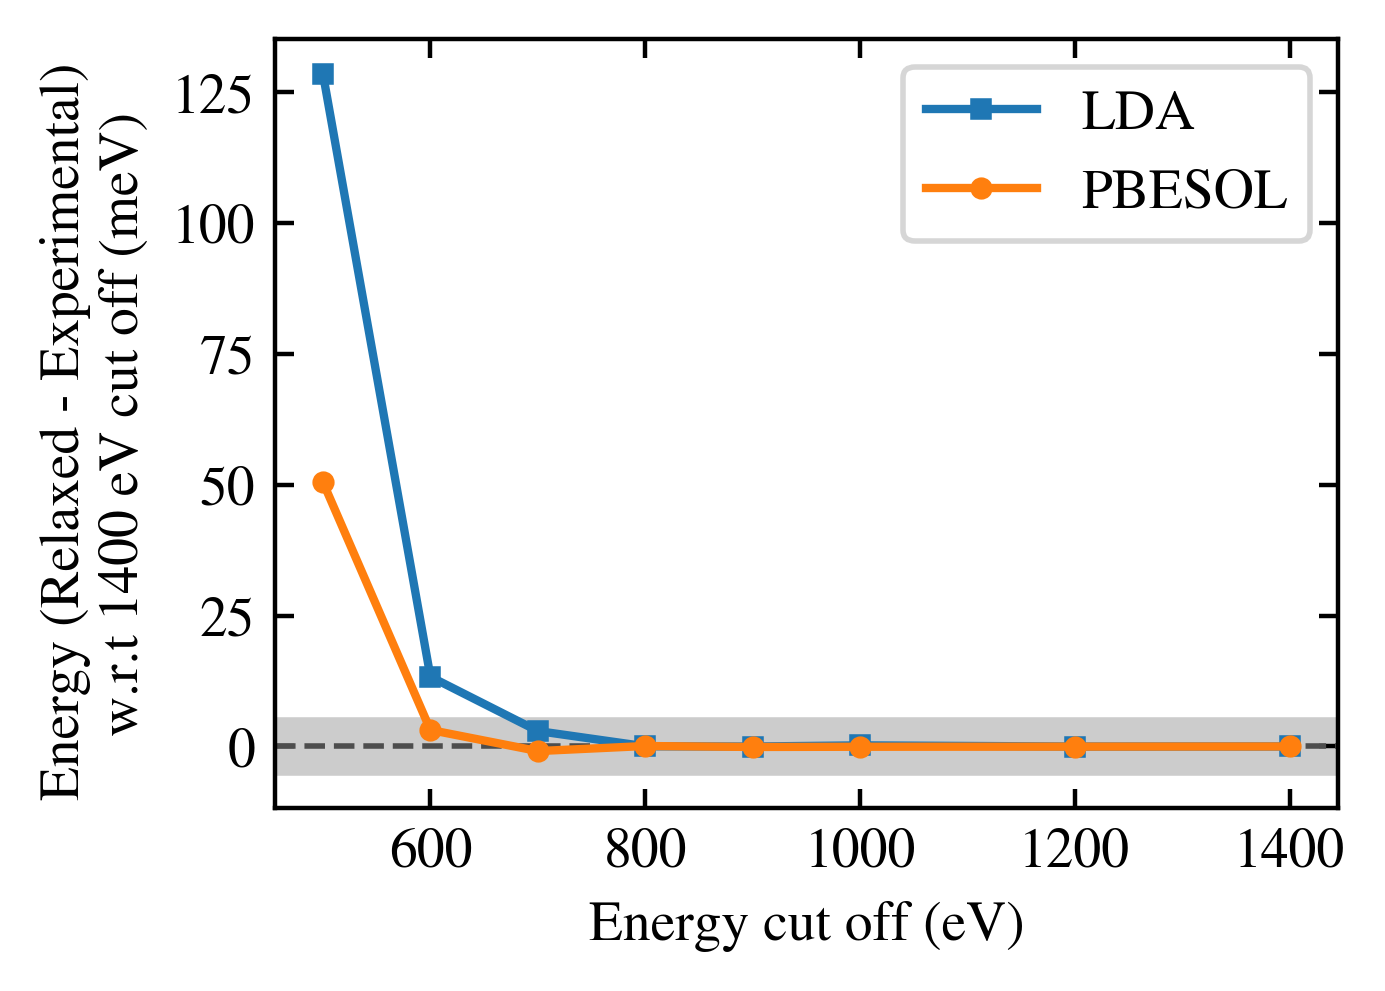

In [49]:
# --- Energy differences ---# 


fig,ax=plt.subplots(1,1,figsize=std_figsize, dpi=400,constrained_layout=True)

# shaded region: +/- 5 meV
ax.axhspan(-5, 5, color="0.8")
ax.axhline(0, color="0.3", lw=1, ls="--")

for xc in ["lda", "pbesol"]:
    totens = encuts_results[xc]['energies_f'] - encuts_results[xc]['energies_i']
    totens *= 1e3 # convert to meV
    ax.plot(encuts_results[xc]['cutoffs'][2:], totens[2:] - np.array(totens)[-1],
            marker=markers[xc],label=f'{xc.upper()}', markersize=3)
    
ax.set_xlabel('Energy cut off (eV)')
ax.set_ylabel('Energy (Relaxed - Experimental) \nw.r.t 1400 eV cut off (meV)')


ax.legend()
# plt.savefig('images/fig1.pdf',format='pdf', bbox_inches='tight')
# fig.show()
##############################

#### 3.2 Forces

Even more important than well-converged energy differences is the convergence of forces. We look at this by taking the initial forces calculated at the experimental structure (i.e. for step 1 of the geometry optimisation).

For this plot, the 'error in max. force' is defined as the max. force in the experimental structure - that calculated at a 1400 eV cut off.

By looking at how the maximum force difference varies with cut off, we get a sense of the error in the forces due to the finite basis.

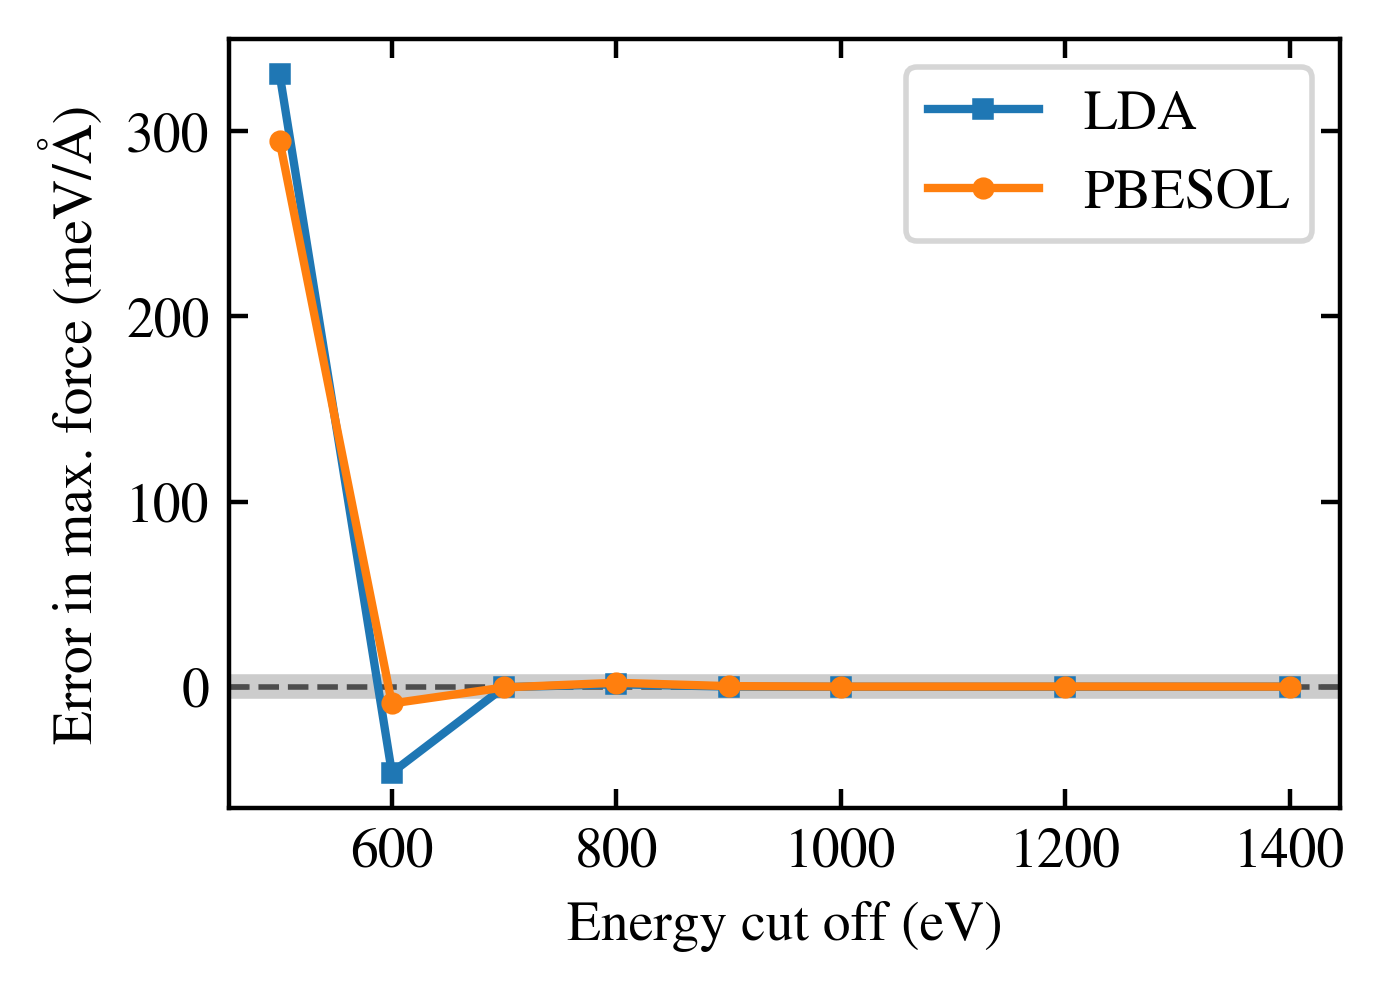

In [50]:
# --- Forces plot ---# 
fig,ax=plt.subplots(1,1,figsize=std_figsize, dpi=400,constrained_layout=True)

# shaded region: +/- 5 meV/A
ax.axhspan(-5, 5, color="0.8")
ax.axhline(0, color="0.3", lw=1, ls="--")

for xc in ["lda", "pbesol"]:
    encuts = encuts_results[xc]['cutoffs'][2:]
    forces = encuts_results[xc]['maxforces_i'][2:] - encuts_results[xc]['maxforces_i'].iloc[-1]
    forces *= 1e3 # convert to meV/A
    ax.plot(encuts, forces,
            marker=markers[xc],label=f'{xc.upper()}', markersize=3)
    
ax.set_xlabel('Energy cut off (eV)')
ax.set_ylabel('Error in max. force (meV/Å)')
ax.legend()

#### 3.3 Stresses

We look at the convergence of stresses by taking the initial stress calculated at the experimental structure (i.e. for step 1 of the geometry optimisation) at different cut offs and comparing that to our most-converged cut off (1400 eV). 


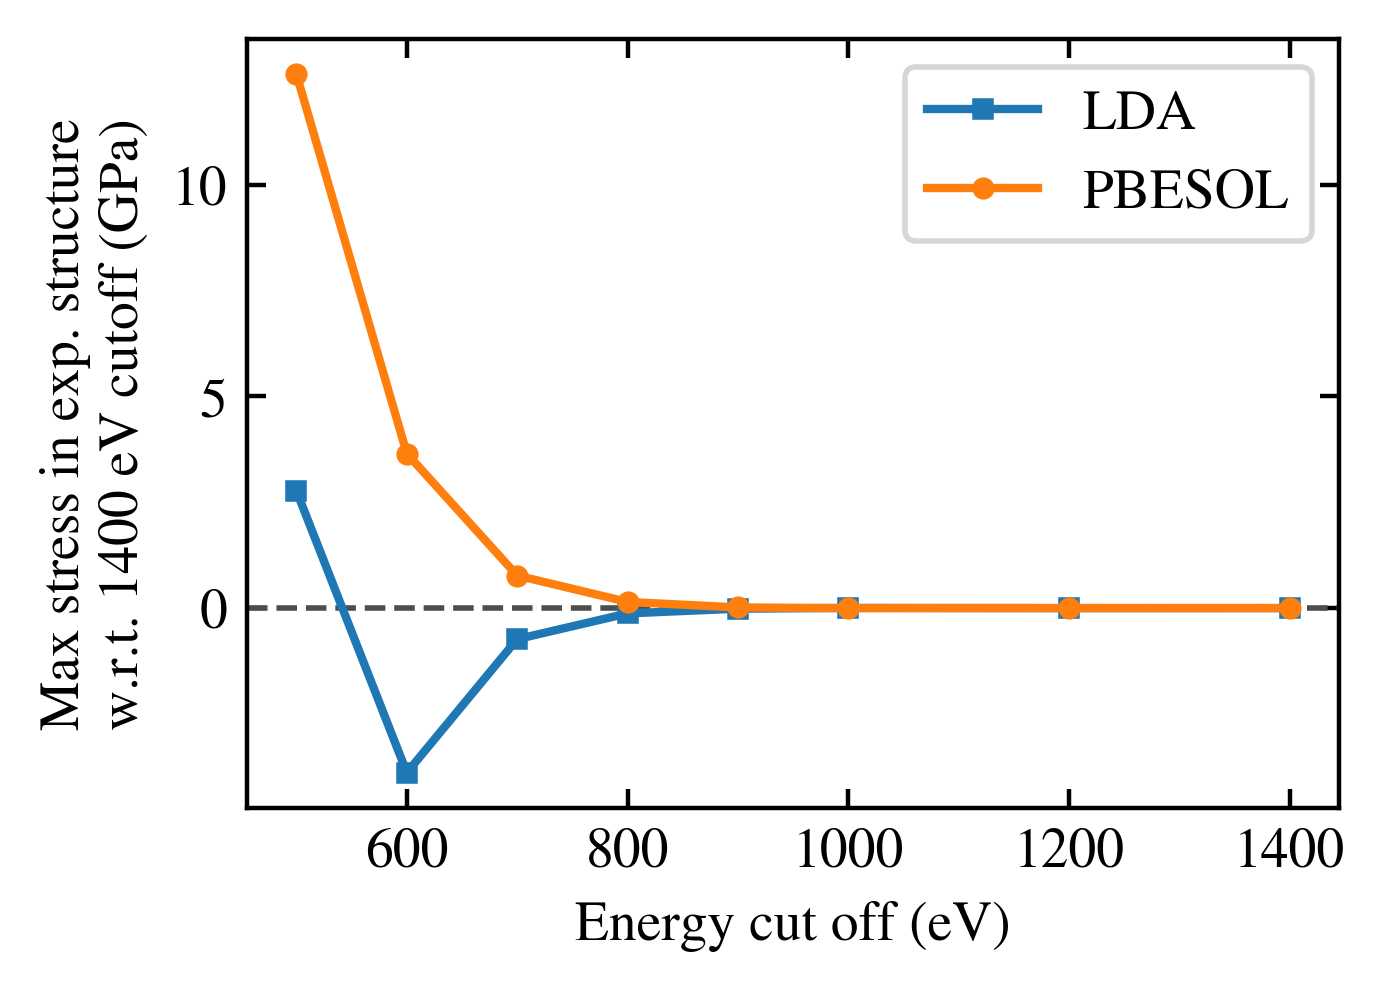

In [51]:
# --- Stresses plot ---# 
fig,ax=plt.subplots(1,1,figsize=std_figsize, dpi=400,constrained_layout=True)
ax.axhline(0, color="0.3", lw=1, ls="--")

for xc in ["lda", "pbesol"]:
    encuts = encuts_results[xc]['cutoffs'][2:]
    stresses = encuts_results[xc]['maxstresses_i'][2:] - encuts_results[xc]['maxstresses_i'].iloc[-1]
    ax.plot(encuts, stresses,
            marker=markers[xc],label=f'{xc.upper()}', markersize=3)
    
ax.set_xlabel('Energy cut off (eV)')
ax.set_ylabel('Max stress in exp. structure\nw.r.t. 1400 eV cutoff (GPa)')
ax.legend()

#### 3.4 Final structure

Finally, we look at how the optimised unit cell depends on the plane wave cut off. We see that the unit cell parameters are certainly well-converged at a cut-off of 900 eV.

Note that this only tells us about the error in the unit cell due to finite basis set -- not the final converged unit cell. For that we must also converge w.r.t. e.g. _k_-points (see below). 

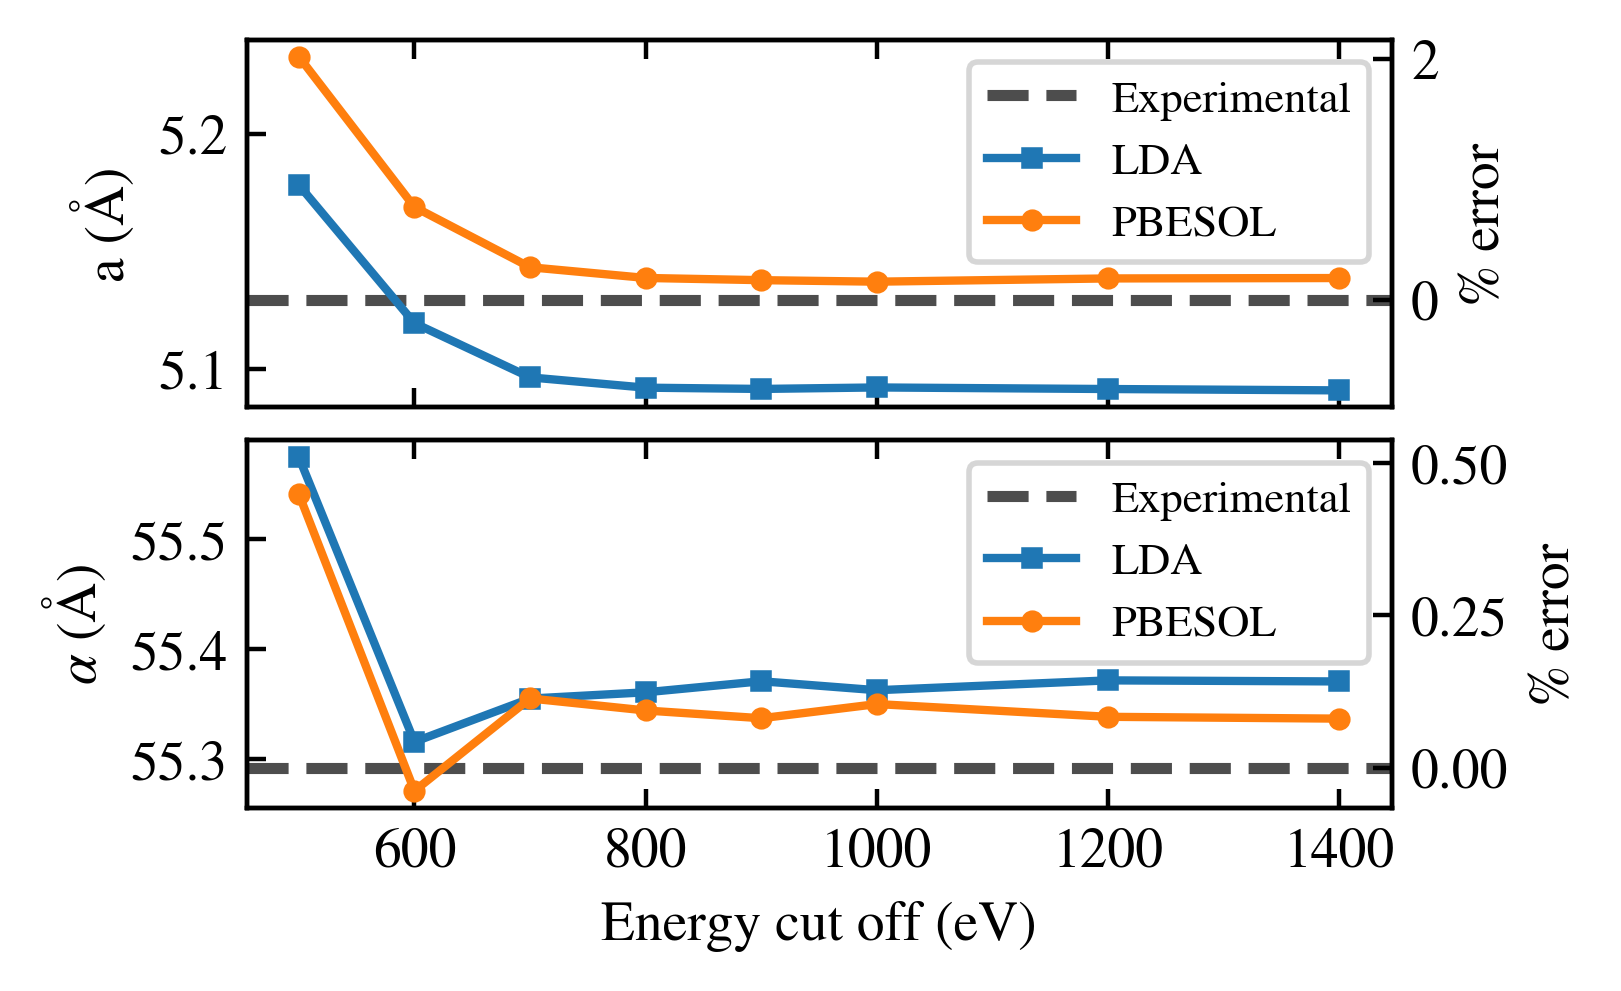

In [52]:
# --- Structure plot ---# 
fig,(ax1, ax2)=plt.subplots(2,1,figsize=(10*cm, 6*cm), dpi=400,constrained_layout=True, sharex=True)
experimental_a = atoms_exp.cell.cellpar()[0]
experimental_alpha = atoms_exp.cell.cellpar()[3]
ax1.axhline(experimental_a, color="0.3", lw=2, ls="--", label="Experimental")
ax2.axhline(experimental_alpha, color="0.3", lw=2, ls="--", label="Experimental")

for xc in ["lda", "pbesol"]:
    encuts = encuts_results[xc]['cutoffs'][2:]
    atoms_list = encuts_results[xc]['atoms'][2:]
    a_s = [atoms.cell.cellpar()[0] for atoms in atoms_list]
    alphas_s = [atoms.cell.cellpar()[3] for atoms in atoms_list]
    ax1.plot(encuts, a_s,
            marker=markers[xc],label=f'{xc.upper()}', markersize=3)
    ax2.plot(encuts, alphas_s,
            marker=markers[xc],label=f'{xc.upper()}', markersize=3)
# show the % error wrt experiment on the right:
#    a
y1, y2=ax1.get_ylim()
ax1r=ax1.twinx()
y1_rel = 100*(y1 - experimental_a) / experimental_a
y2_rel = 100*(y2 - experimental_a) / experimental_a
ax1r.set_ylim(y1_rel, y2_rel)
ax1r.set_ylabel('% error')

#    alpha
y1, y2=ax2.get_ylim()
ax2r=ax2.twinx()
y1_rel = 100*(y1 - experimental_alpha) / experimental_alpha
y2_rel = 100*(y2 - experimental_alpha) / experimental_alpha
ax2r.set_ylim(y1_rel, y2_rel)
ax2r.set_ylabel('% error')



ax2.set_xlabel('Energy cut off (eV)')
ax1.set_ylabel('a (Å)')
ax2.set_ylabel(r'$\alpha$ (Å)')
ax1.legend(fontsize=8)
ax2.legend(fontsize=8)

### 4. _k_-points


In [53]:
# We don't need to re-run the calculations as the outputs are provided.
rerun_calcs = False
if rerun_calcs:
    cutoff = 600
    kpts_range = range(1,9)
    kpts_results = {}
    for xc in ["lda", "pbesol"]:
        for k in kpts_range:
            kpts = [k,k,k]
            atoms = atoms_exp.copy()
            label = f"al2o3_xc-{xc.upper()}_c-{cutoff:04d}_k-{kpts[0]}x{kpts[1]}x{kpts[2]}_geom"
            print(label)
            geom(atoms, cutoff, kpts, xc)

#### Read in the results

Now we extract key information from the results of each geometry optimisation.

In [54]:
cutoff = 600
kpts_range = range(1,9)
kpts_results = {}



for xc in ["lda", "pbesol"]:
    kpts_results[xc] = pd.DataFrame()
    
    energies_i = []
    energies_f = []
    maxforces_i = []
    maxforces_f = []
    maxstresses_i = []
    maxstresses_f = []
    atoms_list = []
    
    for k in kpts_range:
        kpts = [k,k,k]
        label = f"al2o3_xc-{xc.upper()}_c-{cutoff:04d}_k-{kpts[0]}x{kpts[1]}x{kpts[2]}_geom"
        castepfile = f"convergence/cutoff_kpts/{label}.castep"
                # initial energies
        t = !grep "LBFGS: finished iteration     0" $castepfile
        E = float(t[0].split()[-2])
        energies_i.append(E)
        
        # forces:
        t = !grep "|F|max" $castepfile
        maxF_i = float(t[0].split("|")[4])
        maxF_f = float(t[-1].split("|")[4])
        maxforces_i.append(maxF_i)
        maxforces_f.append(maxF_f)
        
        # stresses
        t = !grep "Smax" $castepfile
        maxS_i = float(t[0].split("|")[2])
        maxS_f = float(t[-1].split("|")[2])
        maxstresses_i.append(maxS_i)
        maxstresses_f.append(maxS_f)
        
        # final energies
        atoms = read_castep(castepfile, index=-1)

        energies_f.append(atoms.get_potential_energy())
        
        atoms_list.append(atoms)
        
    kpts_results[xc]["kpts"] = kpts_range
    kpts_results[xc]["energies_i"] = energies_i
    kpts_results[xc]["energies_f"] = energies_f
    kpts_results[xc]["maxforces_i"] = maxforces_i
    kpts_results[xc]["maxforces_f"] = maxforces_f
    kpts_results[xc]["maxstresses_i"] = maxstresses_i
    kpts_results[xc]["maxstresses_f"] = maxstresses_f
    kpts_results[xc]["atoms"] = atoms_list
        
        

#### 4.1 Energy differences

If we plot the difference in total energy between the relaxed and unrelaxed structures with respect to the finest k-point mesh (8x8x8), we get a sense of how well-converged the energy difference is.

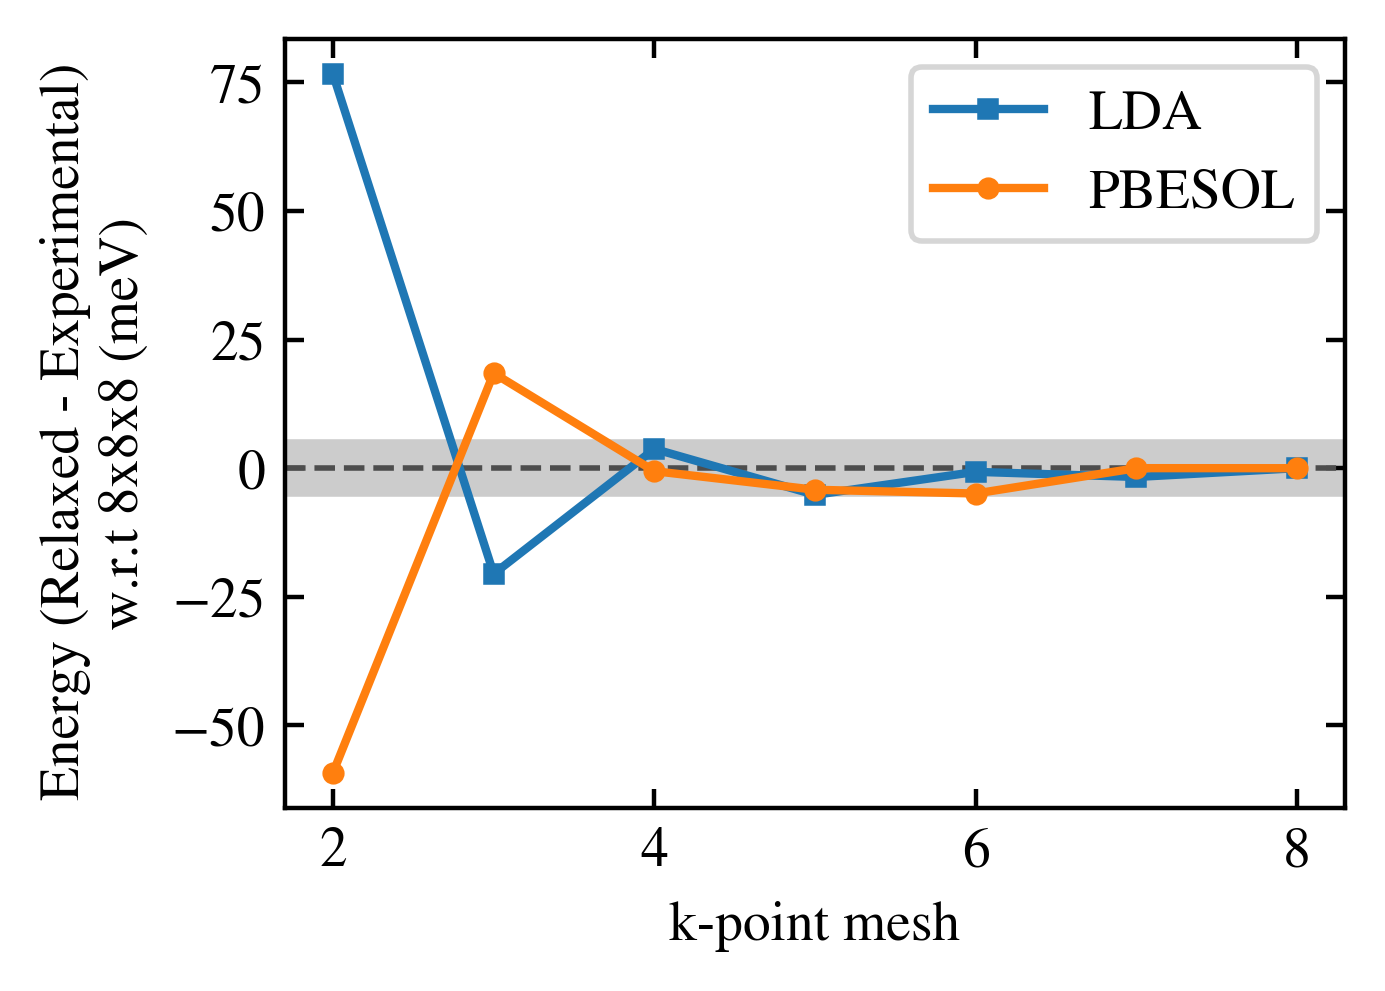

In [55]:
# --- Energy differences ---# 
fig,ax=plt.subplots(1,1,figsize=std_figsize, dpi=400,constrained_layout=True)

# shaded region: +/- 5 meV
ax.axhspan(-5, 5, color="0.8")
ax.axhline(0, color="0.3", lw=1, ls="--")

for xc in ["lda", "pbesol"]:
    totens = kpts_results[xc]['energies_f']- kpts_results[xc]['energies_i']
    totens *= 1e3 # convert to meV
    ax.plot(kpts_range[1:], totens[1:] - np.array(totens)[-1],
            marker=markers[xc],label=f'{xc.upper()}', markersize=3)
    
ax.set_xlabel('k-point mesh')
ax.set_ylabel('Energy (Relaxed - Experimental) \nw.r.t 8x8x8 (meV)')


ax.legend()

#### 4.2 Forces

Even more important than well-converged energy differences is the convergence of forces. We look at this by taking the initial forces calculated at the experimental structure (i.e. for step 1 of the geometry optimisation).

For this plot, the 'error in max. force' is defined as the max. force in the experimental structure - that calculated at an 8x8x8 _k_-point mesh.

By looking at how the maximum force difference varies with the _k_-point sampling, we get a sense of the error in the forces due to the finite sampling.

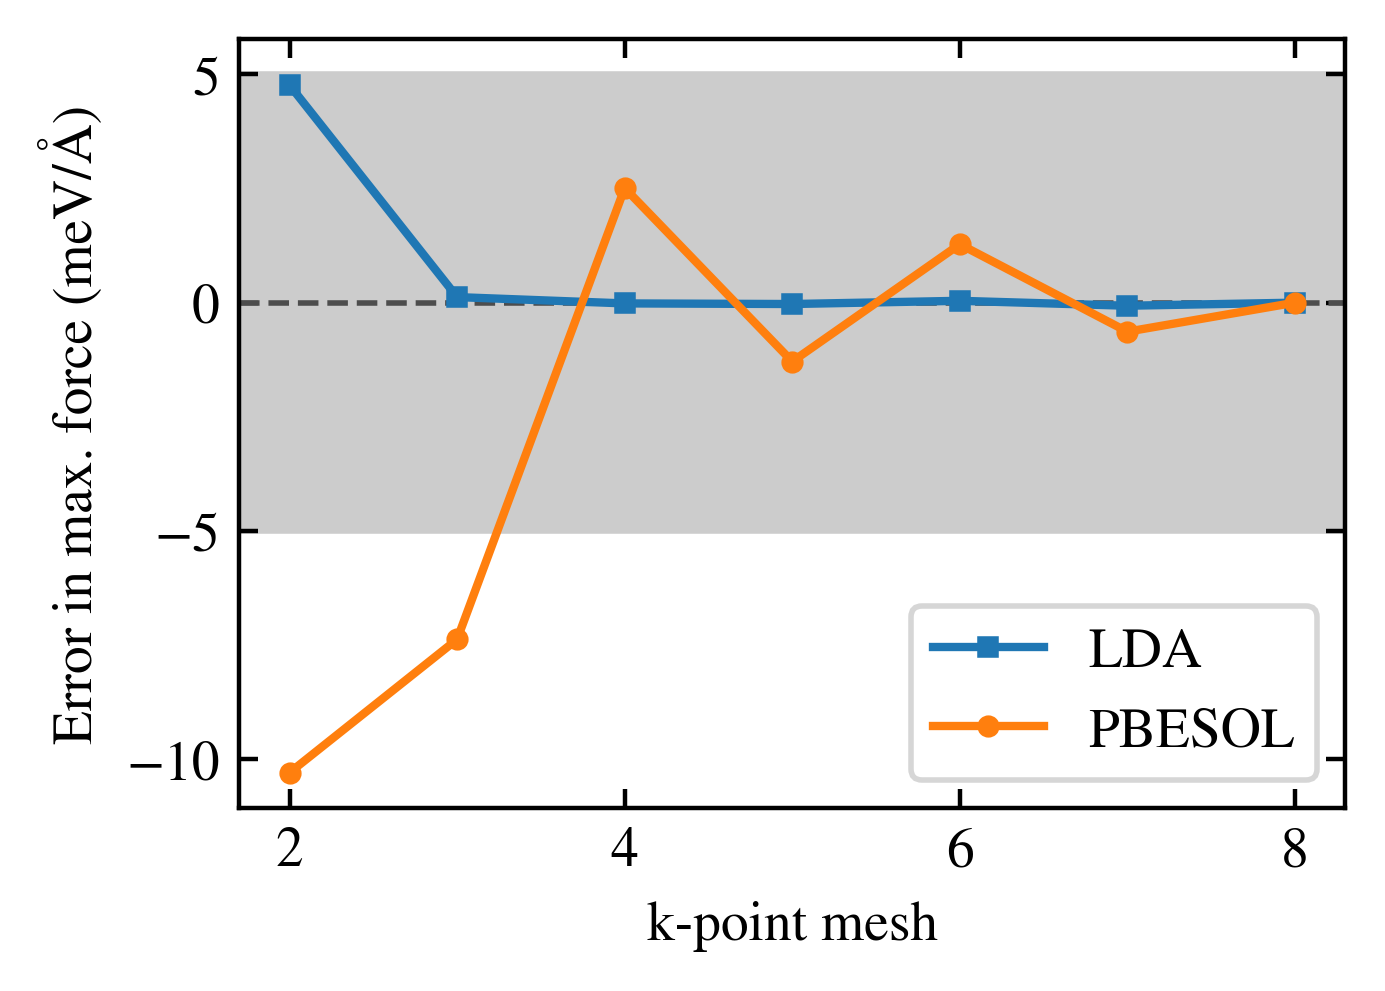

In [56]:
# --- Forces plot ---# 
fig,ax=plt.subplots(1,1,figsize=std_figsize, dpi=400,constrained_layout=True)

# shaded region: +/- 5 meV/A
ax.axhspan(-5, 5, color="0.8")
ax.axhline(0, color="0.3", lw=1, ls="--")

for xc in ["lda", "pbesol"]:
    forces = kpts_results[xc]['maxforces_i'] - kpts_results[xc]['maxforces_i'].iloc[-1]
    forces *= 1e3 # convert to meV/A
    ax.plot(kpts_range[1:], forces[1:],
            marker=markers[xc],label=f'{xc.upper()}', markersize=3)
    
ax.set_xlabel('k-point mesh')
ax.set_ylabel('Error in max. force (meV/Å)')
ax.legend()

#### 4.3 Stresses

We look at the convergence of stresses by taking the initial stress calculated at the experimental structure (i.e. for step 1 of the geometry optimisation) at different _k_-point meshes and comparing that to our most-converged mesh of 8x8x8. 


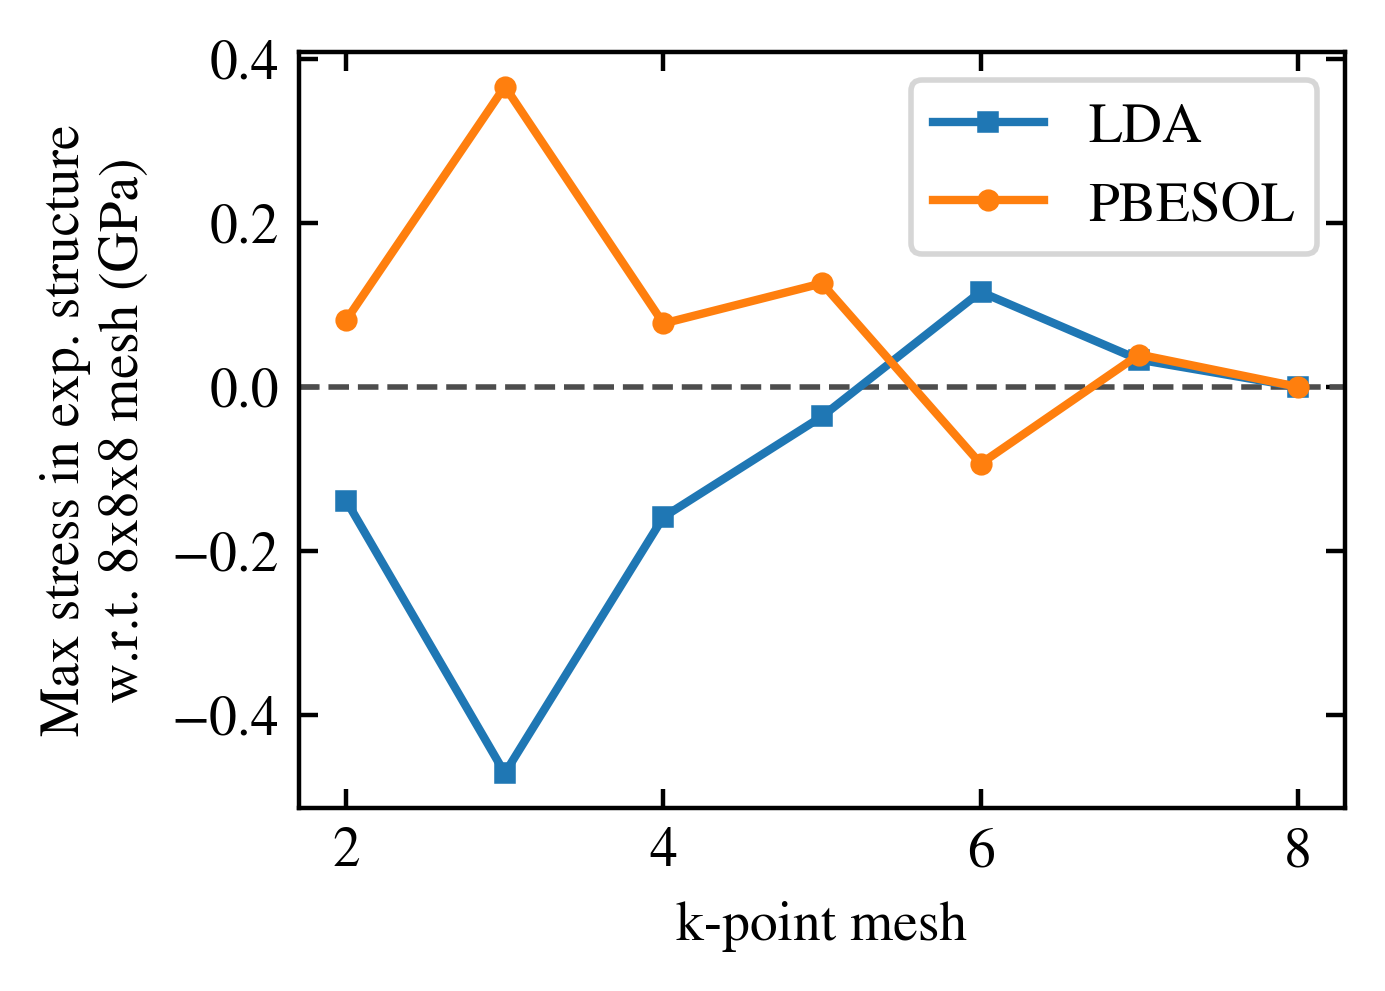

In [57]:
# --- Stresses plot ---# 
fig,ax=plt.subplots(1,1,figsize=std_figsize, dpi=400,constrained_layout=True)


ax.axhline(0, color="0.3", lw=1, ls="--")

for xc in ["lda", "pbesol"]:
    stresses = kpts_results[xc]['maxstresses_i'] - kpts_results[xc]['maxstresses_i'].iloc[-1]
    ax.plot(kpts_range[1:], stresses[1:],
            marker=markers[xc],label=f'{xc.upper()}', markersize=3)
    
ax.set_xlabel('k-point mesh')
ax.set_ylabel('Max stress in exp. structure\nw.r.t. 8x8x8 mesh (GPa)')
ax.legend()

#### 4.4 Final structure

Finally, we look at how the optimised unit cell depends on the _k_-point mesh. We see that the unit cell parameters are certainly well-converged at a _k_-point mesh of 6x6x6.

Note that this only tells us about the error in the unit cell due to finite _k_-point sampling -- not the final converged unit cell. For that we have to use a larger plane-wave cut off (see above)!  

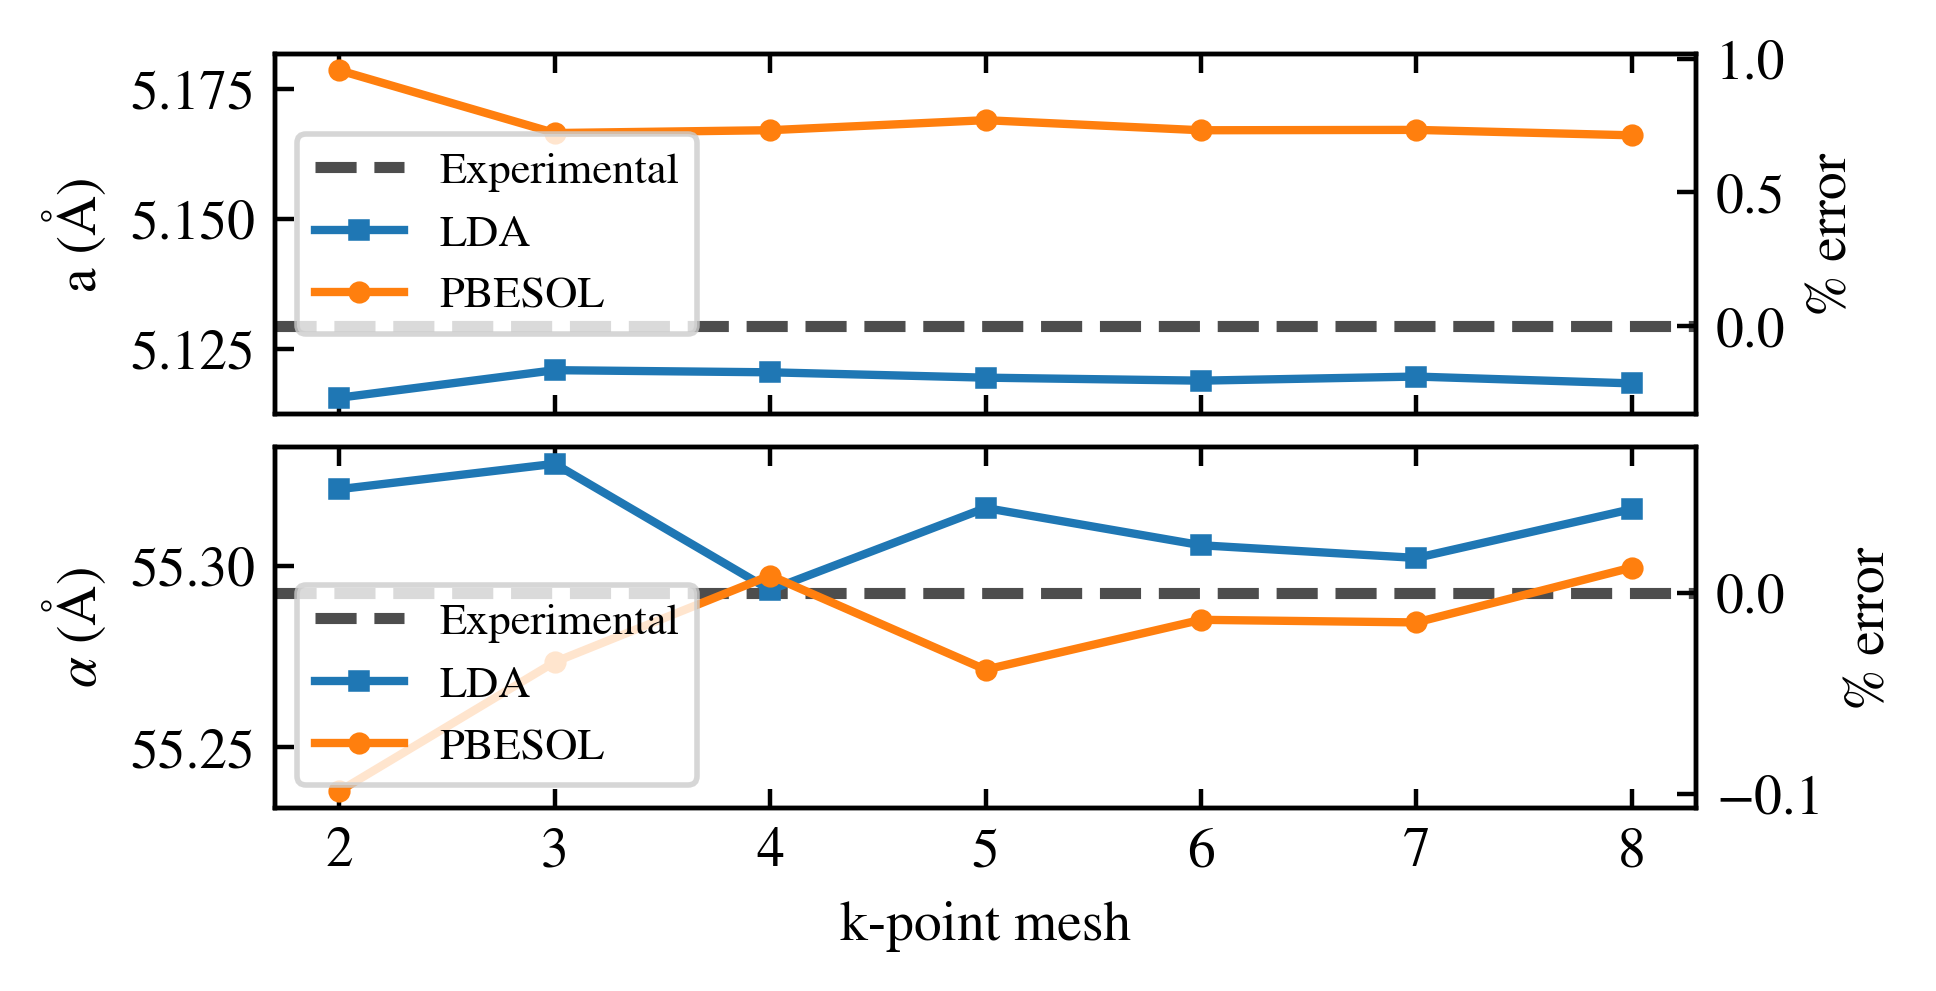

In [58]:
# --- Structure plot ---# 
fig,(ax1, ax2)=plt.subplots(2,1,figsize=(12*cm, 6*cm), dpi=400,constrained_layout=True, sharex=True)
experimental_a = atoms_exp.cell.cellpar()[0]
experimental_alpha = atoms_exp.cell.cellpar()[3]
ax1.axhline(experimental_a, color="0.3", lw=2, ls="--", label="Experimental")
ax2.axhline(experimental_alpha, color="0.3", lw=2, ls="--", label="Experimental")

for xc in ["lda", "pbesol"]:
    atoms_list = kpts_results[xc]['atoms']
    a_s = [atoms.cell.cellpar()[0] for atoms in atoms_list]
    alphas_s = [atoms.cell.cellpar()[3] for atoms in atoms_list]
    ax1.plot(kpts_range[1:], a_s[1:],
            marker=markers[xc],label=f'{xc.upper()}', markersize=3)
    ax2.plot(kpts_range[1:], alphas_s[1:],
            marker=markers[xc],label=f'{xc.upper()}', markersize=3)
# show the % error wrt experiment on the right:
#    a
y1, y2=ax1.get_ylim()
ax1r=ax1.twinx()
y1_rel = 100*(y1 - experimental_a) / experimental_a
y2_rel = 100*(y2 - experimental_a) / experimental_a
ax1r.set_ylim(y1_rel, y2_rel)
ax1r.set_ylabel('% error')

#    alpha
y1, y2=ax2.get_ylim()
ax2r=ax2.twinx()
y1_rel = 100*(y1 - experimental_alpha) / experimental_alpha
y2_rel = 100*(y2 - experimental_alpha) / experimental_alpha
ax2r.set_ylim(y1_rel, y2_rel)
ax2r.set_ylabel('% error')



ax2.set_xlabel('k-point mesh')
ax1.set_ylabel('a (Å)')
ax2.set_ylabel(r'$\alpha$ (Å)')
ax1.legend(fontsize=8)
ax2.legend(fontsize=8)

### 5. Supercell

The CASTEP input and output files for a supercell size test are available in the subdirectory ./convergence/supercell

We ran a geometry-optimisation (with a fixed unit cell) for a $^8\mathrm{Li}^+$ ion in a 2x2x2 and a 3x3x3 unit cell starting at the octahedral interstitial position. We then calculated the electric field gradient tensors in these two cases.

Note that due to a CASTEP bug, there was no space between the atom label and its index for indices larger than 99 in the .magres file produced. These spaces have been manually added in to allow ASE to parse the file correctly.



In [59]:
# read in the structures, together with the EFG tensors

sc222 = read('./convergence/supercell/al2o3_xc-PBESOL_c-0700_k-2x2x2_sc-2x2x2_site-0_nmr.magres')
sc333 = read('./convergence/supercell/al2o3_xc-PBESOL_c-0700_k-1x1x1_sc-3x3x3_site-0_nmr.magres')

##### 5.1 EFG

Note also that these are not quite converged values of $\nu_Q$, but they do allow us to assess the effects of the supercell size. 


In [60]:
def get_nu_Q(atoms,
            Li_idx=0,     # Li index 
            Li8_Q = 32.6, # mbarn for 8Li
            Li8_I = 2.0,  # nuclear spin
            ):

    Vzz = EFGVzz().get(atoms)[Li_idx]
    nu_Q = Vzz*EFG_TO_CHI *Li8_Q / (2*Li8_I)
    nu_Q *= 1e-3 # convert to kHz
    return nu_Q

nuQ_222 = get_nu_Q(sc222)
nuQ_333 = get_nu_Q(sc333)

print(f'''
υ_Q(2x2x2) = {nuQ_222:6.4f} kHz
υ_Q(3x3x3) = {nuQ_333:6.4f} kHz
This is a {100*(nuQ_222 - nuQ_333) / nuQ_333:5.3f}% change
''')



υ_Q(2x2x2) = 71.9782 kHz
υ_Q(3x3x3) = 71.7927 kHz
This is a 0.258% change



##### 5.2 Structural distortion

In [61]:
from ase.geometry import find_mic
def reorder_atoms(atoms_ref, atoms_to_reorder, check_species=True):
    """
    Takes in a reference ASE atoms object and another ASE atoms object to reorder
    
    Loops over reference atoms and, for each one, finds it's closest counterpart in atoms_to_reorder
    (taking into account the periodic boundaries via the minimum image convention).
    
    It finally reorders atoms_to_reorder such that they follow the order in the refernce one. 
    
    
    Returns the re-ordered atoms
    """
    atoms_to_reorder_new_indicies = []

    # loop over reference atoms
    for atom in atoms_ref:
        atoms_ref_index = atom.index

        # temporary copy of atoms_to_reorder
        temp = atoms_to_reorder.copy()
        
        # add atom to temp:
        temp.append(atom)

        # which atom is closest to the newly added atom in atoms_to_reorder
        distances = temp.get_distances(-1, range(len(atoms_to_reorder)), mic=True)

        
        if check_species:
            # loop over closest atoms to atom (in order of closeness)
            for closest_index in np.argsort(distances):
                if atom.symbol == atoms_to_reorder[closest_index].symbol:
                    # if the atom closest is of the same species, then
                    # we're done, otherwise keep going until you find 
                    # one that does match in species
                    atoms_to_reorder_index = closest_index
                    break
                else:
                    pass
            
        else:
            # get index of closest atom
            atoms_to_reorder_index = np.argsort(distances)[0]


        # append to array of new order
        atoms_to_reorder_new_indicies.append(atoms_to_reorder_index)

        
    # apply the new order
    return atoms_to_reorder[atoms_to_reorder_new_indicies]

In [62]:
pristine_structure = read("./pristine_Al2O3/al2o3_xc-PBESOL_c-0900_k-5x5x5_nmr.cell")
pristine_sc222 = pristine_structure.copy() * (2,2,2)
pristine_sc333 = pristine_structure.copy() * (3,3,3)
# add in dummy Li ion in the final relaxed positions 
Li_idx = 0
pristine_sc222.append(sc222[Li_idx])
pristine_sc333.append(sc333[Li_idx])
# reorder atom to match the final structure
pristine_sc222 = reorder_atoms(sc222, pristine_sc222, check_species=True)
pristine_sc333 = reorder_atoms(sc333, pristine_sc333, check_species=True)




def get_displacements(initial, final, Li_idx=0):
    '''
    Gets the distances from the Li ion of each ion in the system, d, and the
    displacement vector moduli, vmod, of each ion from its starting position in pristine Al2O3.
    
    Returns (d,v)
    '''
    not_Li_mask = np.where(np.arange(len(final)) != Li_idx)
    v = initial.get_positions() - final.get_positions()
    # remove net drift 
    vdrift = np.mean(v, axis=0)
    print(f"Net ionic drift: {vdrift} A (should be ~zero)" )
    v = v - vdrift
    v, vmod = find_mic(v, cell=final.cell)

    d = final.get_distances(Li_idx, range(len(final)), mic=True)

    # no point in keeping distance to Li itself...
    d = d[not_Li_mask]
    v = v[not_Li_mask]
    vmod = vmod[not_Li_mask]
    
    return d, vmod


def plot_displacements(d,vmod, ax=None, label=None, marker='o'):
    """
    Plot the displacements due to the Li ion
    as a function of distance from the Li ion. 

    Args:   
        d: distances from the Li
        vmod:  norm of displacements due to the Li
    """
    
    if ax == None:
        fig, ax = plt.subplots(1,1,figsize=std_figsize)
    # Highlight small distortion range: 0.05 A
    ax.axhspan(0, 0.05, color='lightblue', alpha=0.1)
    ax.scatter(d,vmod,
                marker = marker,
                s=12,
                alpha=0.8,
                edgecolors ='none',
                label = label)
    ax.set_xlabel('Distance from Li (Å)')
    ax.set_ylabel('Displacement due to Li (Å)')

    return ax
    


Net ionic drift: [ 1.37169342e-06 -1.20286764e-06  3.39608674e-07] A (should be ~zero)
Net ionic drift: [ 5.43209876e-07 -4.44444444e-07  4.93827160e-07] A (should be ~zero)


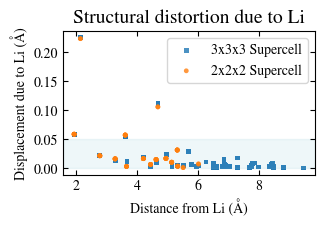

In [63]:
d, vmod =get_displacements(pristine_sc333, sc333, Li_idx=0) 
ax = plot_displacements(d,vmod, label="3x3x3 Supercell", marker = 's')
d, vmod =get_displacements(pristine_sc222, sc222, Li_idx=0) 
ax = plot_displacements(d,vmod, ax, label="2x2x2 Supercell", marker='o')
ax.set_title('Structural distortion due to Li');
ax.legend()
plt.tight_layout()
plt.savefig('./convergence/supercell/Structural_distortion_due_to_Li.png', dpi=300)
plt.savefig('./convergence/supercell/Structural_distortion_due_to_Li.pdf')


ASE provides a simple GUI to quickly visualise a structure or series of structures. You can use this to see the effects of the Li on the surround structure for the 2x2x2 and 3x3x3 supercells like this:

In [64]:
from ase.visualize import view
view([pristine_sc222, sc222, pristine_sc333, sc333])

<Popen: returncode: None args: ['/home/jks/miniconda3/envs/al2o3_SM/bin/pyth...>